In [ ]:
import optuna
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, PredictionErrorDisplay
import seaborn as sns
from catboost import CatBoostRegressor

In [2]:
ch = fetch_california_housing(as_frame=True)

In [3]:
X, y = ch.data, ch.target

In [4]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


<font size = 5>
    В датасете имеется 20 тысяч строк, поэтому для того, чтобы тестовая выборка была достаточно репрезентативной и при этом было достаточно данных для обучения, определим её объём как 20% исходного датасета.
</font>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
data = ch.frame

In [8]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


<Axes: >

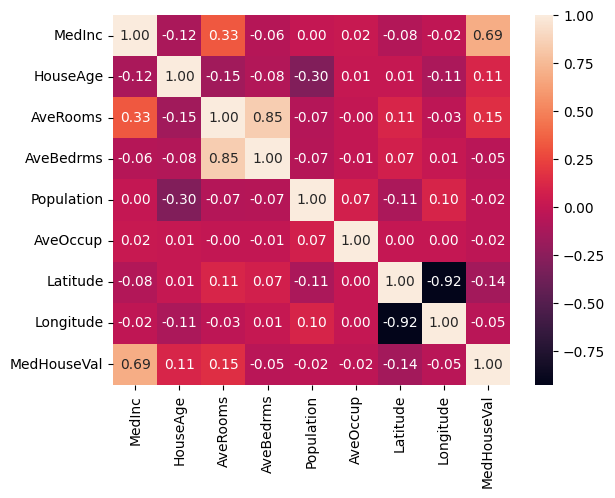

In [ ]:
sns.heatmap(data.corr(), annot = True, fmt=".2f") # Строить надо только с train, иначе - утечка!!!

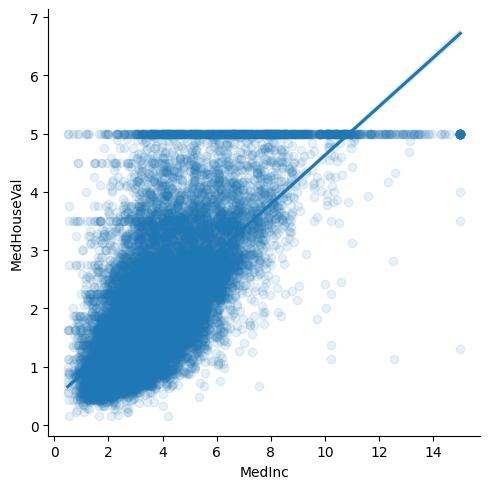

In [10]:
sns.lmplot(x="MedInc", y="MedHouseVal", data=data, scatter_kws={'alpha':0.1})

<font size=5>
    Заметим, что большинство признаков плохо линейно коррелируют с целевой переменной, что делает простую линейную регрессию недостаточно точной. Для работы выберем модель градиентного бустинга CatBoostRegressor, так как она учитывает нелинейные зависимости и взаимодействия между признаками и обеспечивает высокую точность предсказаний.
</font>

<font size=5>
    Для оценки качества модели применим метрики MAE, MSE, RMSE, MAPE и R<sup>2</sup>. В комбинации эти метрики предоставляют полную информацию о предсказывающей способности модели, её устойчивости к выбросам и точности описания зависимостей в данных.
</font>

In [ ]:
def gen_objective(estimator_class, grid, X_train, y_train, **kwargs):
    
    def objective(trial):
        params = {}

        for key, value in grid.items():
            if not hasattr(value, '__iter__'):
                params[key] = value
                continue
            
            if len(value) == 1:
                params[key] = value[0]
                continue
      
            if all(isinstance(x, (int, np.integer)) for x in value) and isinstance(value, (np.ndarray, range)):
                step = value[1] - value[0]
                params[key] = trial.suggest_int(key, min(value), max(value), step=step)
            elif all(isinstance(x, (int, np.integer, float, np.floating)) for x in value) and isinstance(value, (np.ndarray, range)):
                step = value[1] - value[0]
                params[key] = trial.suggest_float(key, min(value), max(value), step=step)
            else:
                params[key] = trial.suggest_categorical(key, value)

        model = estimator_class(**params)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error')
        return -np.mean(scores)

    return objective

In [ ]:
parameters = {
    'iterations': np.arange(500, 2000, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'depth': np.arange(4, 10),
    'l2_leaf_reg': np.arange(1, 11),
    'model_size_reg': np.arange(0, 1.1, 0.1),
    'verbose': False
}

In [13]:
study = optuna.create_study(direction='minimize')
study.optimize(gen_objective(CatBoostRegressor, parameters, X_train, y_train), n_trials=50)

opt_catboost = CatBoostRegressor(**study.best_params)

opt_catboost.fit(X_train, y_train, verbose=False)

y_pred = opt_catboost.predict(X_test)

print(f'MAE: {round(mean_absolute_error(y_test, y_pred), 4)}')
print(f'MSE: {round(mean_squared_error(y_test, y_pred), 4)}')
print(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 4)}')
print(f'R^2: {round(opt_catboost.score(X_test, y_test), 2)}')

study.best_params

[I 2025-09-26 12:55:11,223] A new study created in memory with name: no-name-077f2ff4-3efe-43dd-9264-a24c2df62dae
[I 2025-09-26 12:55:29,474] Trial 0 finished with value: 0.2191774795164425 and parameters: {'iterations': 500, 'learning_rate': 0.05, 'depth': 6, 'l2_leaf_reg': 1, 'model_size_reg': 0.30000000000000004}. Best is trial 0 with value: 0.2191774795164425.
[I 2025-09-26 12:58:38,047] Trial 1 finished with value: 0.21557642217523973 and parameters: {'iterations': 1900, 'learning_rate': 0.01, 'depth': 9, 'l2_leaf_reg': 8, 'model_size_reg': 0.6000000000000001}. Best is trial 1 with value: 0.21557642217523973.
[I 2025-09-26 12:59:36,708] Trial 2 finished with value: 0.20023126965270252 and parameters: {'iterations': 900, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 6, 'model_size_reg': 0.7000000000000001}. Best is trial 2 with value: 0.20023126965270252.
[I 2025-09-26 13:00:01,493] Trial 3 finished with value: 0.20943644194142208 and parameters: {'iterations': 900, 'learning_r

MAE: 0.281
MSE: 0.1897
RMSE: 0.4355
MAPE: 0.1516
R^2: 0.86


{'iterations': 1600,
 'learning_rate': 0.1,
 'depth': 7,
 'l2_leaf_reg': 5,
 'model_size_reg': 0.0}

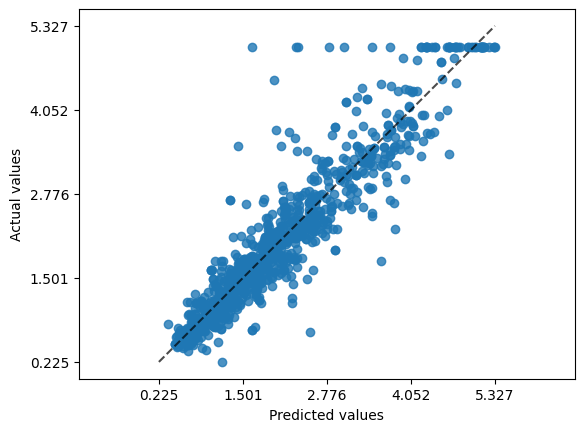

In [15]:
PredictionErrorDisplay.from_predictions(y_test, y_pred, kind="actual_vs_predicted")

<font size = 5>
    По графику видно, что модель предсказывает довольно неплохо, так как точки прижаты к диагональной линии. Предсказания наиболее точны при низких значениях реальной величины, при её росте ошибки начинают расти
</font>

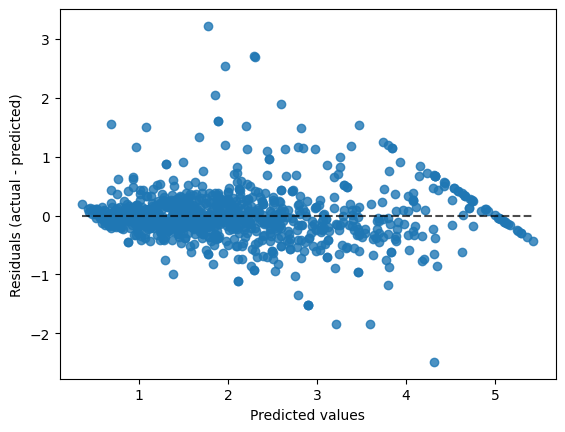

In [17]:
PredictionErrorDisplay.from_predictions(y_test, y_pred, kind="residual_vs_predicted")

<font size = 5>
    Точки этого графика хаотично разбросаны вокруг нуля, что говорит о том, что ошибок нет систематически, однако ближе к самым большим предсказанным значениям точки выстраиваются в линию, что может говорить о том, что модель не способна различать объекты на больших предсказаниях.
</font>